In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
def generate_data(coefficients, from_to, num_points, noise_scale):

    # Gerando valores de x
    x = np.linspace(*from_to, num_points)
    # Gerando ruído
    noise = np.random.normal(0, noise_scale, len(x))
    # Gerando valores de y sem ruído
    y_true = np.polyval(coefficients, x)
    # Gerando valores de y com ruído
    y = y_true + noise

    return x, y, y_true

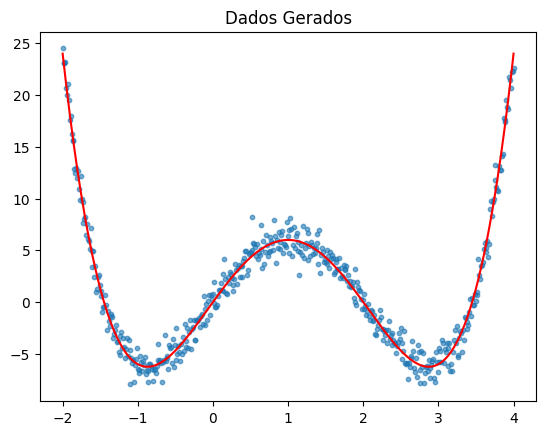

In [3]:
x, y, y_true = generate_data(coefficients=[1, -4, -1, 10, 0], from_to=[-2, 4], num_points=500, noise_scale=1)

plt.scatter(x, y, label="Série com Ruído", alpha=0.6, s=10)
plt.plot(x, y_true, color="red")
plt.title("Dados Gerados")
plt.show()

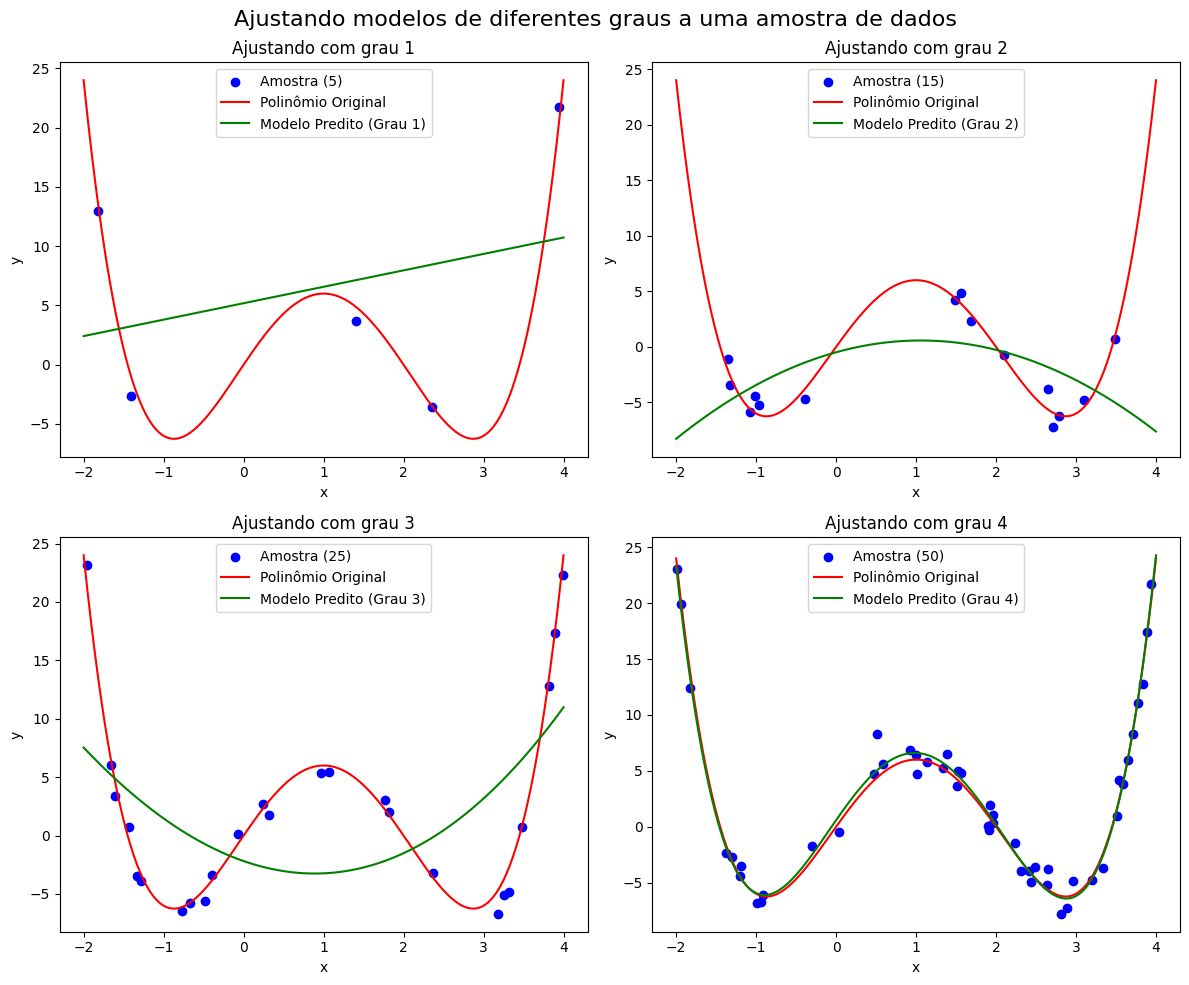

In [4]:
# Função para ajustar um modelo polinomial a uma amostra de dados

def fit_model(x, x_sample, y_sample, degree):
    # Obtendo coeficientes de um polinômio de grau especificado que se ajusta à amostra
    coeffs = np.polyfit(x_sample, y_sample, degree)
    model = np.poly1d(coeffs)
    y_pred = model(x)

    return coeffs, model, y_pred

def plot_model(x_range, x_sample, y_sample, y_true, y_pred, degree, ax):
    # Plotando amostra, polinômio original e modelo ajustado
    ax.scatter(x_sample, y_sample, label=f"Amostra ({len(x_sample)})", color='blue')
    ax.plot(x_range, y_true, color='red', label="Polinômio Original")
    ax.plot(x_range, y_pred, color='green', label="Modelo Predito (Grau {})".format(degree))
    ax.legend()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Ajustando com grau {degree}")

# Criando uma matriz de plots para comparar modelos com diferentes graus
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Ajustando modelos de diferentes graus a uma amostra de dados", fontsize=16)

# Tamanho das amostras que serão usadas para ajustar os modelos de graus 1, 2, 3 e 4
sample_sizes = [5, 15, 25, 50]

# Gerando e ajustando modelos para diferentes graus
for i, sample_size in enumerate(sample_sizes):
    # Obtendo amostra de dados aleatória
    xy = list(zip(x, y))
    np.random.shuffle(xy)
    x_sample, y_sample = zip(*xy[:sample_size])
    degree = i + 1
    
    # Acessamos os plots da matriz usando axs[i // 2, i % 2] (divisa inteira e resto da divisão)
    # i // 2 é a linha e i % 2 é a coluna
    # i varia de 0 a 3, então i // 2 varia de 0 a 1 e i % 2 varia de 0 a 1
    # assim, acessamos os plots (0, 0), (0, 1), (1, 0) e (1, 1) da matriz

    coeffs, model, y_pred = fit_model(x, x_sample, y_sample, degree)
    plot_model(x, x_sample, y_sample, y_true, y_pred, degree, axs[i // 2, i % 2])

plt.tight_layout()
plt.show()


In [5]:
x, y, y_true = generate_data(coefficients=[1, -4, -1, 10, 0], from_to=[-2, 4], num_points=40, noise_scale=1)

In [6]:
# Ajustando Modelos
coeffs_1, model_1, y_pred_1 = fit_model(x=x, x_sample=x, y_sample=y, degree=1)
coeffs_2, model_2, y_pred_2 = fit_model(x=x, x_sample=x, y_sample=y, degree=2)

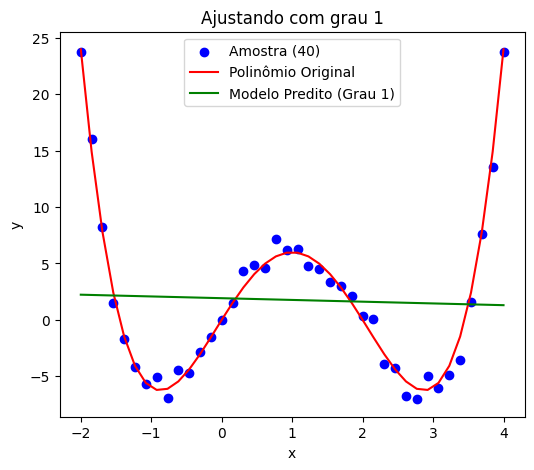

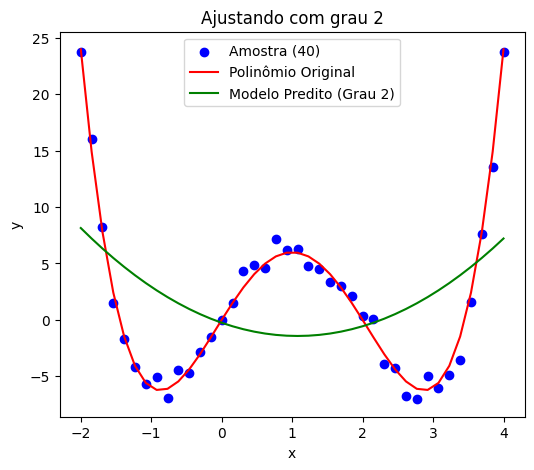

In [7]:
# Plotando Modelos
fig, ax = plt.subplots(figsize=(6, 5))
plot_model(x_range=x, y_sample=y, x_sample=x, y_true=y_true, y_pred=y_pred_1, degree=1, ax=ax)
fig2, ax2 = plt.subplots(figsize=(6, 5))
plot_model(x_range=x, y_sample=y, x_sample=x, y_true=y_true, y_pred=y_pred_2, degree=2, ax=ax2)


In [8]:
def split_data(x, y, validation_size):
    # Embaralhando os índices dos dados
    indices = np.arange(len(x))
    np.random.shuffle(indices)

    # Dividindo os dados em conjuntos de treinamento e validação
    validation_indices = indices[:validation_size]
    training_indices = indices[validation_size:]
    x_validation, y_validation = x[validation_indices], y[validation_indices]
    x_training, y_training = x[training_indices], y[training_indices]

    return x_training, y_training, x_validation, y_validation

In [9]:
def evaluate_model(x_training, y_training, x_validation, y_validation, degree):
    # Ajustando o modelo com os dados de treinamento
    coeffs = np.polyfit(x_training, y_training, degree)
    model = np.poly1d(coeffs)

    # Predizendo valores de y com o modelo para os dados de validação
    y_pred = model(x_validation)

    def calculate_error(y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    # Calculando o erro de validação
    error = calculate_error(y_validation, y_pred)

    return error, coeffs


def monte_carlo_experiment(x, y, degrees, validation_sizes, num_iterations):
    errors = np.zeros((len(validation_sizes), len(degrees), num_iterations))
    coeffs_dict = {degree:{i : [] for i in validation_sizes} for degree in degrees}
    coeffs_variances = {degree:{i : [] for i in validation_sizes} for degree in degrees}


    for d, degree in enumerate(degrees):
        for v, validation_size in enumerate(validation_sizes):
            for i in range(num_iterations):
                x_training, y_training, x_validation, y_validation = split_data(x, y, validation_size=validation_size)
                error, coeffs = evaluate_model(x_training, y_training, x_validation, y_validation, degree)

                errors[v, d, i] = error
                coeffs_dict[degree][validation_size].append(list(coeffs))

                # if (i + 1) % 10 == 0:
                #     print(f"Iteração {i + 1}/{num_iterations} - Tamanho do conj. valid.: {validation_size} - Grau: {degree}")
                #     print(f"Erro de Validação: {error:.4f} - Coeficientes: {coeffs}\n")

    # Obtendo a variância de cada coeficiente para cada grau e tamanho de validação
    for degree in coeffs_dict.keys():
        for validation_size in coeffs_dict[degree].keys():
            coeffs_variances[degree][validation_size] = list(np.var(coeffs_dict[degree][validation_size], axis=0))

    # Calculando a média dos erros para cada grau e tamanho de validação
    mean_errors = np.mean(errors, axis=2)
    

    return mean_errors, coeffs_variances


In [10]:
# Parâmetros do experimento de Monte Carlo
degrees = [1, 2]  # Modelos de grau 1 e 2
validation_sizes = [5, 10, 15, 20, 25, 30]  # Tamanhos de amostra para validação
num_iterations = 10000  # Número de iterações do experimento

mean_errors, coeffs_variances = monte_carlo_experiment(x, y, degrees, validation_sizes, num_iterations)

Iteração 10/10000 - Tamanho do conj. valid.: 5 - Grau: 1
Erro de Validação: 35.0002 - Coeficientes: [0.11484484 2.18906008]

Iteração 20/10000 - Tamanho do conj. valid.: 5 - Grau: 1
Erro de Validação: 36.6086 - Coeficientes: [-0.32083811  2.78081873]

Iteração 30/10000 - Tamanho do conj. valid.: 5 - Grau: 1
Erro de Validação: 26.4209 - Coeficientes: [-0.04209571  2.32865281]

Iteração 40/10000 - Tamanho do conj. valid.: 5 - Grau: 1
Erro de Validação: 33.6405 - Coeficientes: [0.17000645 1.31024634]

Iteração 50/10000 - Tamanho do conj. valid.: 5 - Grau: 1
Erro de Validação: 150.0423 - Coeficientes: [0.41156622 1.5045566 ]

Iteração 60/10000 - Tamanho do conj. valid.: 5 - Grau: 1
Erro de Validação: 49.8297 - Coeficientes: [-0.00801712  2.5665089 ]

Iteração 70/10000 - Tamanho do conj. valid.: 5 - Grau: 1
Erro de Validação: 206.3944 - Coeficientes: [0.78184145 0.38526303]

Iteração 80/10000 - Tamanho do conj. valid.: 5 - Grau: 1
Erro de Validação: 167.4996 - Coeficientes: [-1.10683419  2.

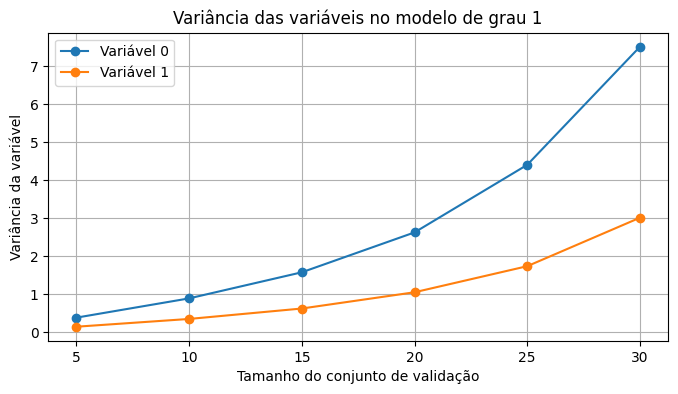

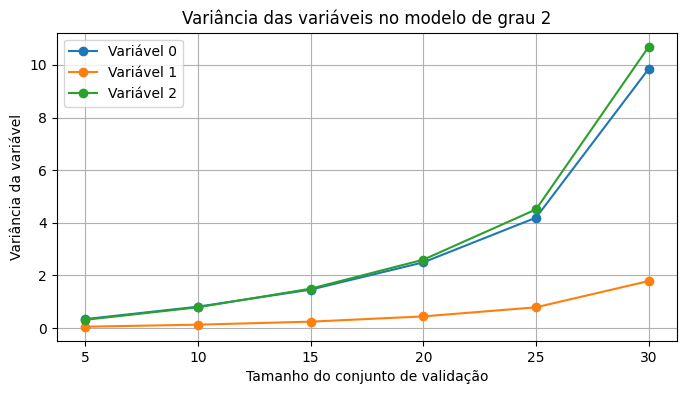

In [11]:
for (degree,var_count) in [(1,2),(2,3)]:
    plt.figure(figsize=(8, 4))
    plt.title(f"Variância das variáveis no modelo de grau {degree}")
    plt.xlabel("Tamanho do conjunto de validação")
    plt.ylabel("Variância da variável")
    for var_index in range(0,var_count):  # Variables 1 and 2
        vars = [coeffs_variances[degree][sample_size][var_index - 1] for sample_size in coeffs_variances[1]]
        plt.plot(list(coeffs_variances[degree].keys()), vars,  marker='o', label=f"Variável {var_index }")
    plt.legend()
    plt.grid(True)
    plt.show()


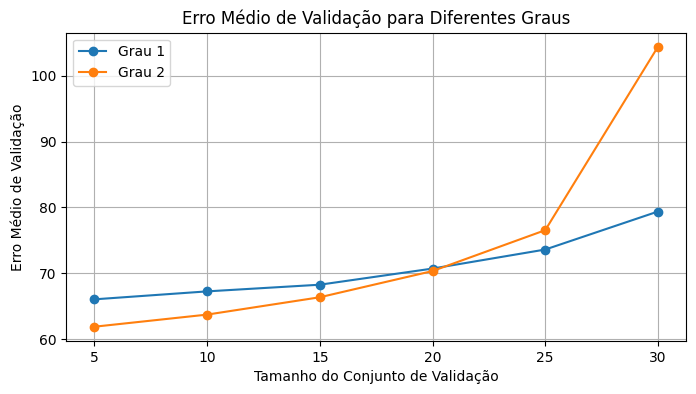

In [12]:
# Plot Validation Errors
plt.figure(figsize=(8, 4))
for d, degree in enumerate(degrees):
    plt.plot(validation_sizes, mean_errors[:, d], marker='o', label=f"Grau {degree}")
plt.xlabel("Tamanho do Conjunto de Validação")
plt.ylabel("Erro Médio de Validação")
plt.title("Erro Médio de Validação para Diferentes Graus")
plt.legend()
plt.grid(True)
plt.show()